In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms, models
from torch import tensor
from sklearn.model_selection import train_test_split
import pandas as pd
from PIL import Image
import os

In [5]:
pwd

'/Users/shrijansshetty/dev/GeneratedImageDetector/ResNet50'

In [6]:
# Define the root directory of the dataset
dataset_root = '../Dataset'
# Load the train CSV file
train_df = pd.read_csv(os.path.join(dataset_root, 'train.csv'), index_col=0)
# Load the test CSV file
test_df = pd.read_csv(os.path.join(dataset_root, 'test.csv'))

train_df.head()

,file_name,label
0,train_data/a6dcb93f596a43249135678dfcfc17ea.jpg,1
1,train_data/041be3153810433ab146bc97d5af505c.jpg,0
2,train_data/615df26ce9494e5db2f70e57ce7a3a4f.jpg,1
3,train_data/8542fe161d9147be8e835e50c0de39cd.jpg,0
4,train_data/5d81fa12bc3b4cea8c94a6700a477cf2.jpg,1


In [7]:
# Split into training and validation (80% train, 20% validation)
train_df, val_df = train_test_split(train_df, test_size=0.2, random_state=42, stratify=train_df['label'])

print(f"Train size: {len(train_df)}, Validation size: {len(val_df)}")

Train size: 63960, Validation size: 15990


In [8]:
class ImageDataset(Dataset):
    def __init__(self, df, root_dir, transform=None, is_test=False):
        self.df = df
        self.root_dir = root_dir
        self.transform = transform
        self.is_test = is_test  # Flag to indicate if this is the test dataset

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        if self.is_test:
            # Use the first column (assumed to be 'id' or 'file_name')
            img_path = os.path.join(self.root_dir, self.df.iloc[idx, 0])  
        else:
            # Use column names instead of hardcoded index
            img_path = os.path.join(self.root_dir, self.df['file_name'].iloc[idx])  
            label = int(self.df['label'].iloc[idx])  

        image = Image.open(img_path).convert('RGB')

        if self.transform:
            image = self.transform(image)

        if self.is_test:
            return image, -1 
        else:
            return image, label

In [9]:
# Training Transform (with data augmentation)
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    # transforms.RandomHorizontalFlip(),  # Augmentation: Randomly flip images
    # transforms.RandomRotation(10),      # Augmentation: Rotate images slightly
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Test/Validation Transform (NO augmentation)
test_transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Keep it consistent
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


In [10]:
# Create datasets
train_dataset = ImageDataset(train_df, dataset_root, transform=train_transform, is_test=False)
val_dataset = ImageDataset(val_df, dataset_root, transform=test_transform, is_test=False)
test_dataset = ImageDataset(test_df, dataset_root, transform=test_transform, is_test=True)

# Create dataloaders
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

# Print dataset sizes
print(f'Train dataset size: {len(train_dataset)}')
print(f'Validation dataset size: {len(val_dataset)}')
print(f'Test dataset size: {len(test_dataset)}')


Train dataset size: 63960
Validation dataset size: 15990
Test dataset size: 5540


In [39]:
from torchvision.models import resnet50, ResNet50_Weights

# Load ResNet50 model with pre-trained weights
model = resnet50(weights=ResNet50_Weights.DEFAULT)

# Modify the fully connected (fc) layer for binary classification
model.fc = nn.Linear(model.fc.in_features, 2)
model.load_state_dict(torch.load("best_model.pth", map_location=torch.device('cpu')))

/var/folders/0z/h3j36kwj6qb9gp2_c6z48bbr0000gn/T/ipykernel_2528/3551722438.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("best_model.p

<All keys matched successfully>

In [40]:
for param in model.parameters():
    param.requires_grad = False  # Freeze all layers

for param in model.layer4.parameters():  # Unfreeze the last ResNet block
    param.requires_grad = True  
for param in model.fc.parameters():
    param.requires_grad = True  # Keep final layer trainable

In [41]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

In [42]:
from torch.optim.lr_scheduler import StepLR
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.0005, weight_decay=1e-4)
#AdamW helps improve generalization.
scheduler = StepLR(optimizer, step_size=5, gamma=0.1)  # Reduce LR by 10x every 5 epochs

In [43]:
num_epochs = 20  # Increased to give early stopping a chance to work
patience = 3  # Number of epochs to wait before stopping if no improvement
best_val_acc = 0  # Track the best validation accuracy
counter = 0  # Counter for patience

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    # Training loop
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()

        # Calculate training accuracy
        _, predicted = torch.max(outputs, 1)
        correct_train += (predicted == labels).sum().item()
        total_train += labels.size(0)
    
    train_accuracy = 100 * correct_train / total_train
    avg_loss = running_loss / len(train_loader)

    # Validation loop
    model.eval()
    correct_val = 0
    total_val = 0

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            correct_val += (predicted == labels).sum().item()
            total_val += labels.size(0)

    val_accuracy = 100 * correct_val / total_val

    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {avg_loss:.4f}, Training Accuracy: {train_accuracy:.2f}%, Validation Accuracy: {val_accuracy:.2f}%')
    print(f'Learning Rate: {scheduler.get_last_lr()[0]}')  # Print current learning rate
    
    # Update learning rate
    scheduler.step()
    
    # Early Stopping Logic
    if val_accuracy > best_val_acc:
        best_val_acc = val_accuracy
        counter = 0  # Reset patience counter
        torch.save(model.state_dict(), 'best_model.pth')  # Save best model
    else:
        counter += 1
        if counter >= patience:
            print(f"Early stopping triggered after {epoch+1} epochs.")
            break  # Stop training if no improvement for `patience` epochs

Epoch 1/20, Loss: 0.0119, Training Accuracy: 99.58%, Validation Accuracy: 99.30%
Learning Rate: 0.0005
Epoch 2/20, Loss: 0.0062, Training Accuracy: 99.79%, Validation Accuracy: 99.56%
Learning Rate: 0.0005


KeyboardInterrupt: 

In [44]:
model.eval()
predictions = []

with torch.no_grad():
    for images, _ in test_loader:  # No labels in the test set
        images = images.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        predictions.extend(predicted.cpu().numpy())

# Ensure IDs are correctly extracted from test_df
submission_df = pd.DataFrame({'id': test_df.iloc[:, 0], 'label': predictions})

In [46]:
submission_df.to_csv('submission.csv', index=False)

# Check the first few rows
print(submission_df.head())

                                                  id  label
0  test_data_v2/1a2d9fd3e21b4266aea1f66b30aed157.jpg      0
1  test_data_v2/ab5df8f441fe4fbf9dc9c6baae699dc7.jpg      0
2  test_data_v2/eb364dd2dfe34feda0e52466b7ce7956.jpg      0
3  test_data_v2/f76c2580e9644d85a741a42c6f6b39c0.jpg      0
4  test_data_v2/a16495c578b7494683805484ca27cf9f.jpg      0


In [19]:
from sklearn.metrics import precision_score, recall_score, f1_score

# Collect predictions and labels
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in val_loader:  # Use val_loader or test_loader
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Compute metrics
precision = precision_score(all_labels, all_preds, average='binary')
recall = recall_score(all_labels, all_preds, average='binary')
f1 = f1_score(all_labels, all_preds, average='binary')

print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')

Precision: 0.9902
Recall: 0.9967
F1 Score: 0.9935


In [47]:
device

device(type='cpu')

In [21]:
if torch.cuda.is_available():
    device = torch.device('cuda')
    print('GPU is available')
else:
    device = torch.device('cpu')
    print('GPU is not available, using CPU instead')

GPU is not available, using CPU instead


In [48]:
def classify_image(model, image_tensor, class_names):
    with torch.no_grad():
        outputs = model(image_tensor)
        _, predicted = torch.max(outputs, 1)  # Get the class index with the highest score
        return class_names[predicted.item()]
# Step 3: Preprocess the input image
def preprocess_image(image_path):
    transform = transforms.Compose([
        transforms.Resize((224, 224)),  # Resize to match model input size
        transforms.ToTensor(),         # Convert to tensor
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize
    ])
    image = Image.open(image_path).convert("RGB")
    return transform(image).unsqueeze(0)  # Add batch dimension

In [54]:
# Path to the saved weights and input image
weights_path = "best_model.pth"
image_path = "/Users/shrijansshetty/dev/GeneratedImageDetector/Dataset/train_data/ffd74e6a0c314e969df97f49dfcb8b6f.jpg"
class_names = ["Real", "Fake"]  # Replace with your actual class names
num_classes = 2  # Number of classes in your dataset

# Load the model and preprocess the image
image_tensor = preprocess_image(image_path)

# Classify the image
result = classify_image(model, image_tensor, class_names)
print(f"Predicted Class: {result}")

Predicted Class: Real


/Users/shrijansshetty/miniconda3/envs/Lab2/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/shrijansshetty/miniconda3/envs/Lab2/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/var/folders/0z/h3j36kwj6qb9gp2_c6z48bbr0000gn/T/ipykernel_2528/2533870059.py:13: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code d

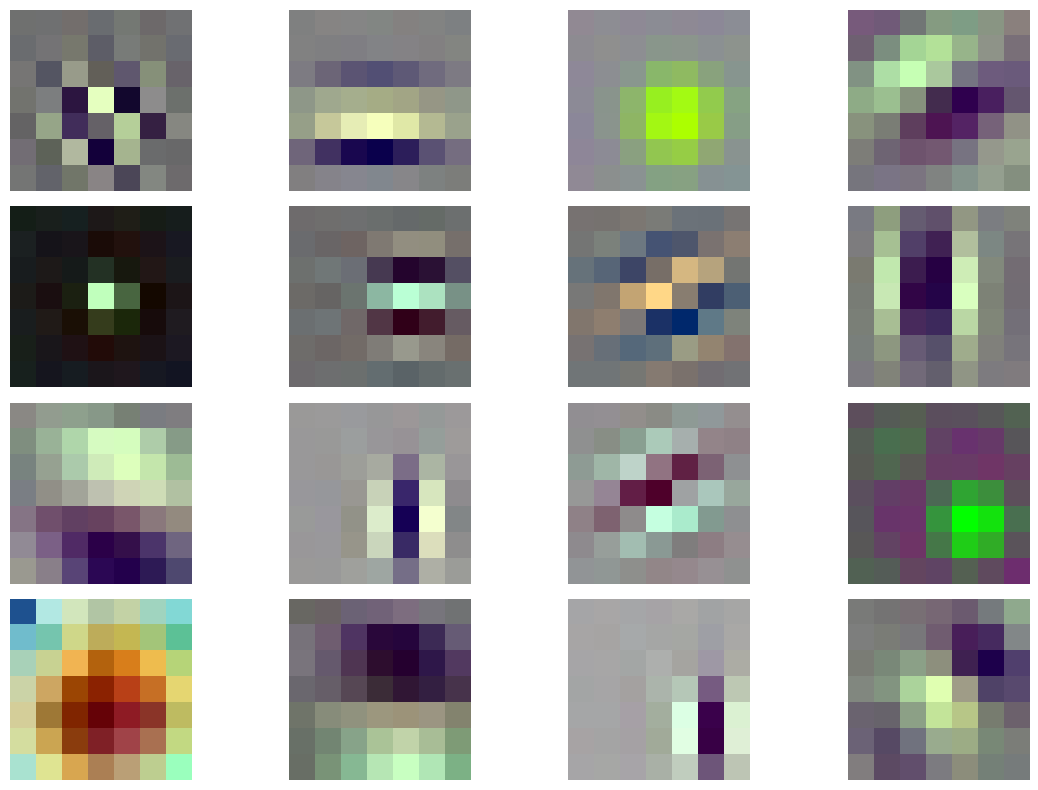

In [50]:
import torch
import torchvision.models as models
import matplotlib.pyplot as plt
import numpy as np

# Step 1: Load the trained model
# Replace 'best_model.pth' with the path to your trained model weights
# Load ResNet50 model with pre-trained weights
model = resnet50(pretrained=True)

# Modify the fully connected (fc) layer for binary classification
model.fc = nn.Linear(model.fc.in_features, 2)
model.load_state_dict(torch.load("best_model.pth", map_location=torch.device('cpu')))
model.eval()

# Step 2: Access the first convolutional layer
# For ResNet50, the first convolutional layer is `conv1`
conv1_weights = model.conv1.weight.data.cpu().numpy()  # Shape: (64, 3, 7, 7)

# Step 3: Normalize the weights for visualization
def normalize_kernel(kernel):
    kernel = (kernel - kernel.min()) / (kernel.max() - kernel.min())  # Normalize to [0, 1]
    return kernel

# Step 4: Visualize the kernels
def visualize_kernels(kernels, num_kernels=16):
    kernels = kernels[:num_kernels]  # Select the first `num_kernels` filters
    num_cols = 4  # Number of columns in the plot
    num_rows = (num_kernels + num_cols - 1) // num_cols  # Calculate rows dynamically

    fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, 8))
    axes = axes.flatten()

    for i, ax in enumerate(axes):
        if i < len(kernels):
            kernel = kernels[i]
            kernel = normalize_kernel(kernel)  # Normalize the kernel
            # For RGB kernels, transpose to (H, W, C) for visualization
            if kernel.shape[0] == 3:  # RGB kernel
                kernel = np.transpose(kernel, (1, 2, 0))
            ax.imshow(kernel, cmap="viridis" if kernel.shape[-1] != 3 else None)
            ax.axis("off")
        else:
            ax.axis("off")  # Hide unused subplots

    plt.tight_layout()
    plt.show()

# Step 5: Call the visualization function
visualize_kernels(conv1_weights)